### Analyze intensity data from cardiac ultrasound

In [667]:
# import dependencies

#data structure and io
import glob
import os
import pandas as pd

# general computation 
import numpy as np

# plotting
import matplotlib.pyplot as plt 

# signal processing 
from scipy.ndimage import gaussian_filter,gaussian_filter1d
from scipy import signal 
from scipy.fft import fft, fftfreq
from scipy import stats

save_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/figures/"

In [512]:
def norm_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def cardiac_cylce_index(ts,sig,lower = 5,upper = 15):
    """ finds indicies for estimated end-diastolic volume 
    by first filtering the signal for heart rate followed by 
    find_peaks to estimate start and end. 

    input: 
    ts: time in seconds
    sig: signal with clear oscillatory comonent 
    lower: lower frequency for filtering
    upper: upper frequency for filtering 
    
    output: 
    hr: estimated heart rate in Hz
    peak_locs: index of end-diastolic volume """

    fs = 1/stats.mode(np.diff(ts))[0][0]
    a,b = signal.butter(3,(5,15),btype="bandpass",fs = 48)
    filt_sig = signal.filtfilt(a,b,sig)
    peak_locs = signal.find_peaks(filt_sig)
    hr = len(ts[peak_locs[0]])/(ts[-1] - ts[0])
    return hr, peak_locs,filt_sig

def plot_signal(df,save_path):

    t = np.array(df["time after burst"])
    sig = np.array(df.Mean_bmode)
    filt_sig = df.filt_sig
    peak_locs = signal.find_peaks(filt_sig) 

    fig, axs = plt.subplots(3,1,figsize = (30,10))
    axs = axs.ravel()

    fig.subplots_adjust(hspace = 1,wspace = .5)
    axs[0].plot(t,filt_sig)
    axs[0].scatter(t[peak_locs[0]],filt_sig[peak_locs[0]],c='r')
    axs[0].legend(['filtered signal 5 - 15 Hz','Estimated End-Diastolic Volume'])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Normalized Magnitude')
    axs[0].set_title('End-diastolic volume estimated from peak intensity of filtered ultrasound data')

    axs[1].plot(t,sig)
    # axs[1].scatter(t,sig,c='grey')
    axs[1].scatter(t[peak_locs[0]],sig[peak_locs[0]],c='r')
    axs[1].legend(['raw signal','peaks from filtering'])
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Intensity')
    axs[1].set_title('')

    axs[2].plot(t,filt_sig)
    sns.scatterplot(t,filt_sig,hue = df["phase"],palette = "colorblind")
    # axs[2].legend(['filtered signal 5 - 15 Hz','Estimated End-Diastolic Volume'])
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Normalized Magnitude')
    axs[2].set_title('Cardiac cycle by phase')

    plt.savefig(save_path+os.sep+"cardiac_cycle_peaks.svg",dpi = 300, bbox_inches = "tight")

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [320]:
df = pd.read_csv("//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/713_burst3_all.csv")
# df = df.loc[df["time after burst"] > 0, :]
df

,,time,time after burst,pw_ROI1,pw_ROI2,pw_ROI3,Mean_bmode,ventricle
0,1,0.020833,-6.729167,28.450,11.907,18.044,44.581,44.078
1,2,0.041667,-6.708333,19.079,10.423,13.489,45.205,33.871
2,3,0.062500,-6.687500,23.836,12.001,15.495,45.804,32.533
3,4,0.083333,-6.666667,36.586,20.158,18.916,46.692,49.466
4,5,0.104167,-6.645833,31.807,15.255,19.016,45.588,36.122
...,...,...,...,...,...,...,...,...
626,627,13.062500,6.312500,21.640,15.651,14.646,43.901,39.116
627,628,13.083333,6.333333,19.652,10.798,14.253,42.714,44.011
628,629,13.104167,6.354167,27.745,14.855,18.628,42.640,38.602
629,630,13.125000,6.375000,25.348,11.010,22.843,42.837,33.348


## For a single burst event, how does the intensity change across all ROIs

we'll also smooth the intensity to reduce the influence of known mediators (heartrate and respiration)

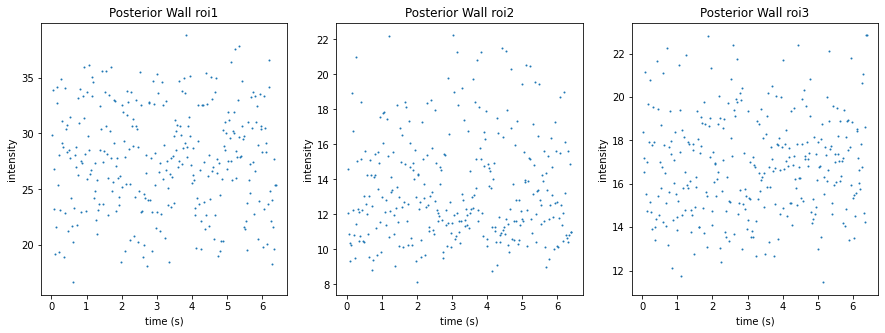

In [4]:
# scatter intensity over time
fig,axs = plt.subplots(1,3,figsize = (15,5))
axs.ravel()

axs[0].scatter(df["time after burst"],df["pw_ROI1"],s=1)
axs[1].scatter(df["time after burst"],df["pw_ROI2"],s=1)
axs[2].scatter(df["time after burst"],df["pw_ROI3"],s=1)

axs[0].set_title("Posterior Wall roi1")
axs[1].set_title("Posterior Wall roi2")
axs[2].set_title("Posterior Wall roi3")

for ax in axs:  
    ax.set_xlabel("time (s)")
    ax.set_ylabel("intensity")

There is no linear association with intensity over time, though there is some striations appearing. Intensity changes as a function of the cardiac cycle, so lets parse the data based on cylce position. 

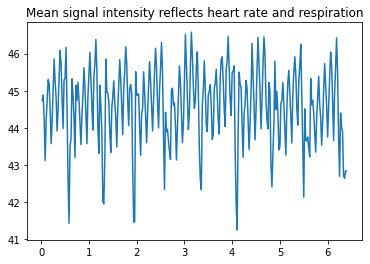

In [51]:
plt.plot(df["time after burst"],df["Mean_bmode"])
plt.title("Mean signal intensity reflects heart rate and respiration")
plt.show()

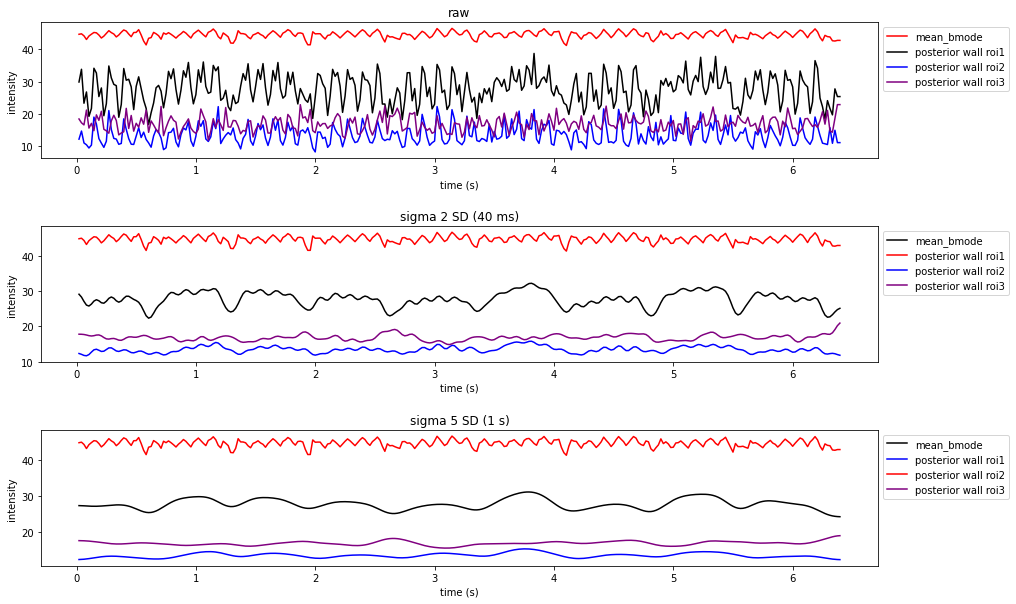

In [6]:
fig,axs = plt.subplots(3,1,figsize=(15,10))
axs.ravel()
fig.subplots_adjust(hspace = .5)

axs[0].plot(df["time after burst"],df.Mean_bmode,color = "r")
axs[0].plot(df["time after burst"],df.pw_ROI1,color = "k")
axs[1].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI1),2),color = "k")
axs[2].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI1),5),color = "k")

axs[1].plot(df["time after burst"],df.Mean_bmode,color = "r")
axs[0].plot(df["time after burst"],df.pw_ROI2,color = "blue")
axs[1].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI2),2),color = "blue")
axs[2].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI2),5),color = "blue")

axs[2].plot(df["time after burst"],df.Mean_bmode,color = "r")
axs[0].plot(df["time after burst"],df.pw_ROI3,color = "purple")
axs[1].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI3),2),color = "purple")
axs[2].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI3),5),color = "purple")

# axs[0].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[1].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[2].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

axs[0].set_title("raw")
axs[1].set_title("sigma 2 SD (40 ms)")
axs[2].set_title("sigma 5 SD (1 s)")

for ax in axs:  
    ax.legend(["mean_bmode","posterior wall roi1","posterior wall roi2","posterior wall roi3","burst epoch"],bbox_to_anchor=(1,1),loc = "upper left",ncol=1)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("intensity")

    plt.savefig(save_path+"smoothed_signal.svg",dpi = 300, bbox_inches = "tight")

### Normalize the intensity of ROI relative to meaan intensity (meab_bmode)

additionally, lets average the posterior wall ROIs as they exhibited similar intensity changes over time

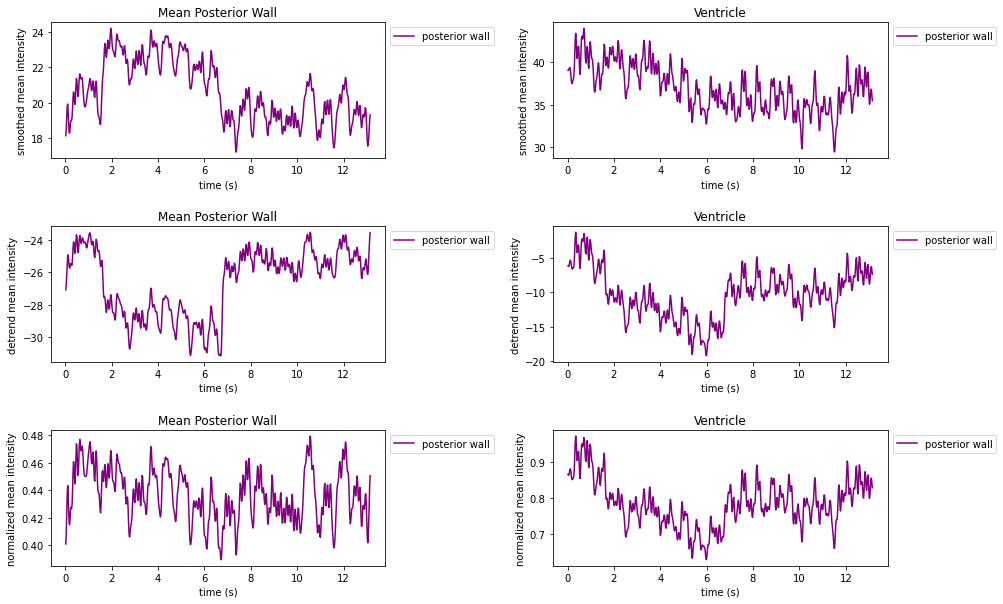

In [321]:
# compute data
cols = ['pw_ROI1','pw_ROI2','pw_ROI3']

prop_pw = df[cols].mean(axis=1)/df['Mean_bmode']  
prop_ventricle = np.array(df.ventricle/df.Mean_bmode)

detrend_pw = df[cols].mean(axis=1) - df['Mean_bmode']  
detrend_ventricle = np.array(df.ventricle - df.Mean_bmode)

smoothed_pw = df[cols].mean(axis=1) 
smoothed_ventricle = np.array(df.ventricle)


fig,axs = plt.subplots(3,2,figsize=(15,10))
axs = axs.ravel()
fig.subplots_adjust(hspace = .5,wspace = .5)

axs[0].plot(df.time,gaussian_filter(smoothed_pw,2),color = "purple")
axs[1].plot(df.time,gaussian_filter(smoothed_ventricle,2),color = "purple")

axs[2].plot(df.time,gaussian_filter(np.array(detrend_pw),2),color = "purple")
axs[3].plot(df.time,gaussian_filter(np.array(detrend_ventricle),2),color = "purple")

axs[4].plot(df.time,gaussian_filter(prop_pw,2),color = "purple")
axs[5].plot(df.time,gaussian_filter(prop_ventricle,2),color = "purple")


# axs[0].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[1].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

# axs[2].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[3].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

# axs[4].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[5].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

axs[0].set_title("Mean Posterior Wall")
axs[1].set_title("Ventricle")
axs[0].set_ylabel("smoothed mean intensity")
axs[1].set_ylabel("smoothed mean intensity")

axs[2].set_title("Mean Posterior Wall")
axs[3].set_title("Ventricle")
axs[2].set_ylabel("detrend mean intensity")
axs[3].set_ylabel("detrend mean intensity")

axs[4].set_title("Mean Posterior Wall")
axs[5].set_title("Ventricle")
axs[4].set_ylabel("normalized mean intensity")
axs[5].set_ylabel("normalized mean intensity")
for ax in axs:  
    ax.legend(["posterior wall","burst epoch"],bbox_to_anchor=(1,1),loc = "upper left",ncol=1)
    ax.set_xlabel("time (s)")


plt.savefig(save_path+"normalize_approach_burst_intensity.svg",dpi = 300, bbox_inches = "tight")

### Examine Intensity relative to phase of cardiac cylcle (Part 1)

We can estimate the time at  end-diastolic volumn by finding the peaks of oscillations from 5 - 13 Hz (corresponds to heart rates from around 300 - 800 BPM). 

C:\Users\schafferlab\anaconda3\envs\ephys_tools\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


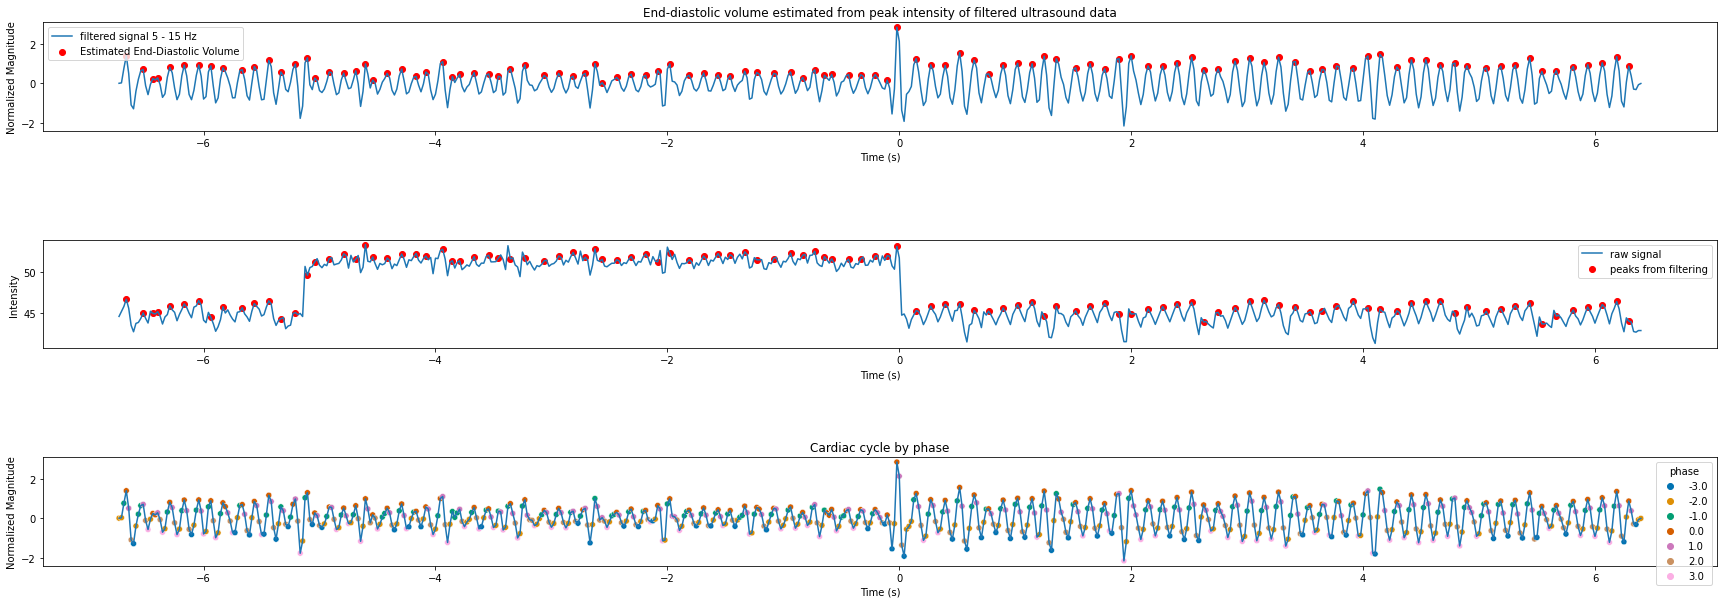

<Figure size 432x288 with 0 Axes>

In [322]:
from scipy import signal 
from scipy.fft import fft, fftfreq
from scipy import stats

t = np.array(df["time after burst"])
sig = np.array(df.Mean_bmode)

hr, peak_locs, filt_sig = cardiac_cylce_index(t,sig,lower = 5,upper = 13)
# add phase to data frame
df["phase"] = np.round(np.angle(signal.hilbert(filt_sig)))

fig, axs = plt.subplots(3,1,figsize = (30,10))
axs = axs.ravel()

fig.subplots_adjust(hspace = 1,wspace = .5)
axs[0].plot(t,filt_sig)
axs[0].scatter(t[peak_locs[0]],filt_sig[peak_locs[0]],c='r')
axs[0].legend(['filtered signal 5 - 15 Hz','Estimated End-Diastolic Volume'])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Normalized Magnitude')
axs[0].set_title('End-diastolic volume estimated from peak intensity of filtered ultrasound data')

peak_locs = signal.find_peaks(filt_sig) 
axs[1].plot(t,sig)
# axs[1].scatter(t,sig,c='grey')
axs[1].scatter(t[peak_locs[0]],sig[peak_locs[0]],c='r')
axs[1].legend(['raw signal','peaks from filtering'])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Intensity')
axs[1].set_title('')

axs[2].plot(t,filt_sig)
sns.scatterplot(t,filt_sig,hue = df["phase"],palette = "colorblind")
# axs[2].legend(['filtered signal 5 - 15 Hz','Estimated End-Diastolic Volume'])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Normalized Magnitude')
axs[2].set_title('Cardiac cycle by phase')


plt.show()
plt.savefig(save_path+"cardiac_cycle_peaks.svg",dpi = 300, bbox_inches = "tight")

### Examine Intensity relative to phase of cardiac cylcle (Part 2) 

Afterwards, we can align intensities by time between these peaks. 

<Figure size 1440x720 with 0 Axes>

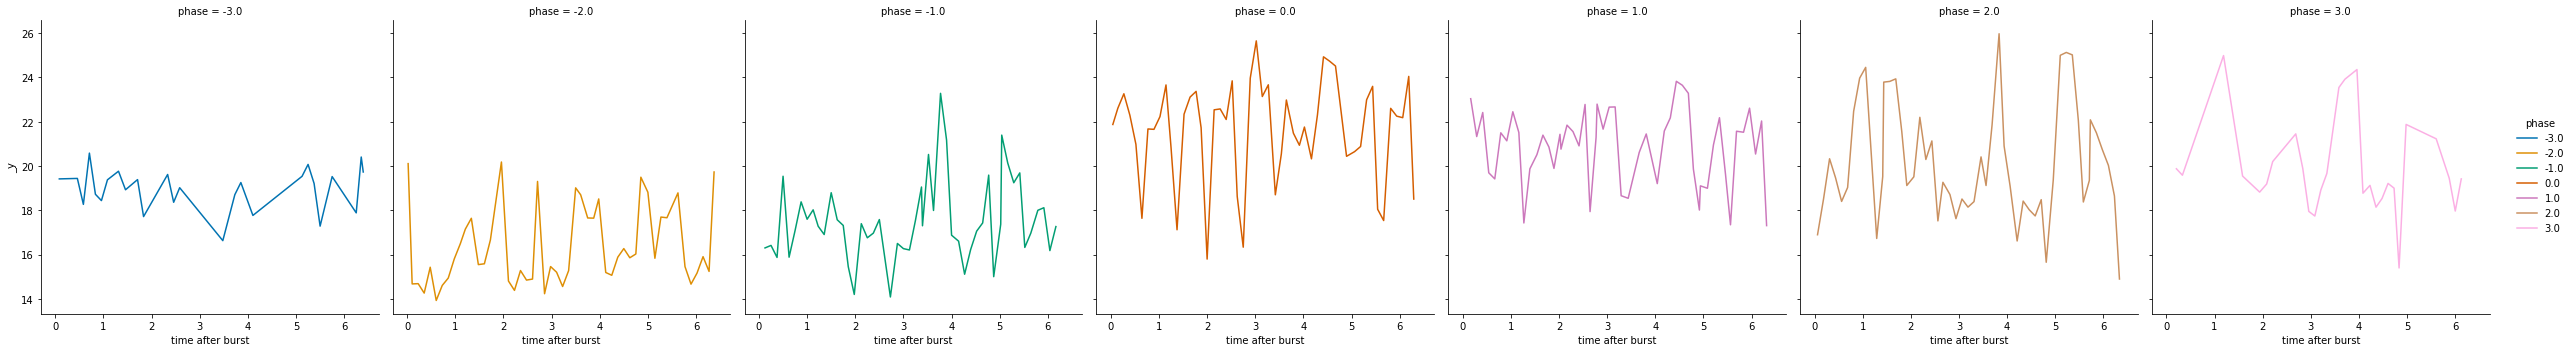

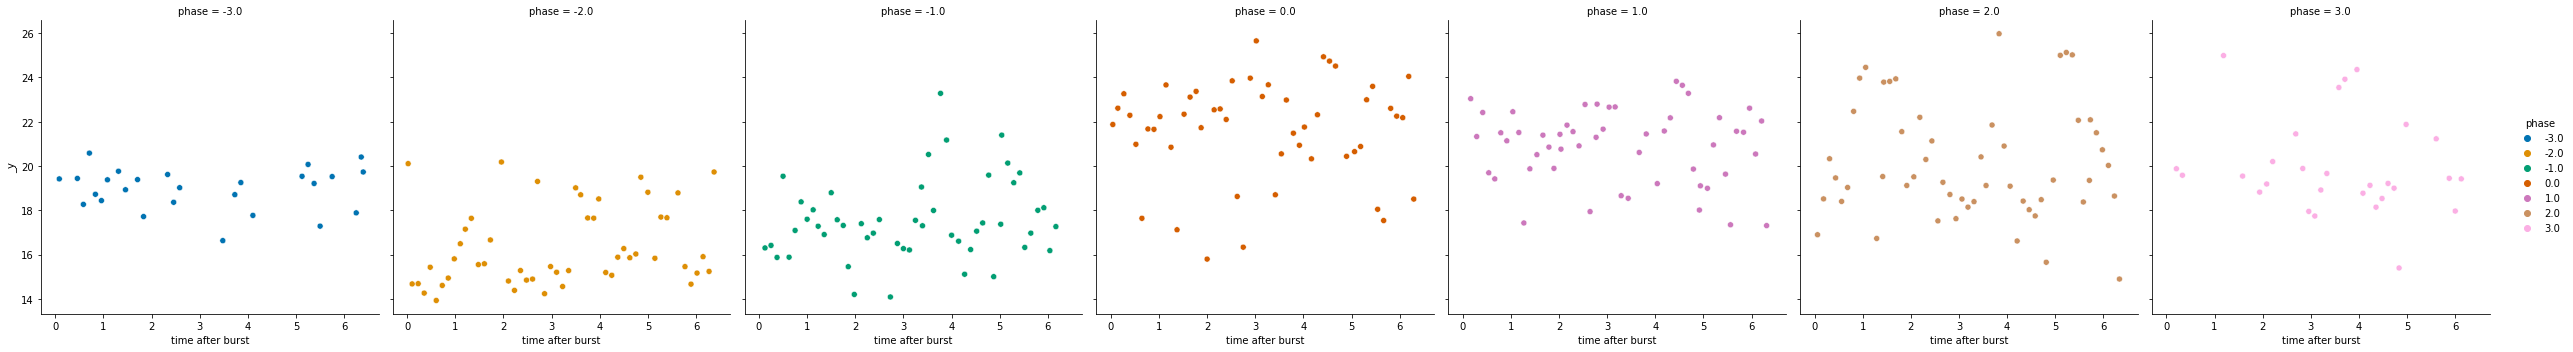

In [44]:
import seaborn as sns

cols = ['ROI 1','ROI 2','ROI 3']

def plot_intensity_by_phase(df):
    """ 
    plots intensity data by phase
    input:
    df: 
    
    
    """
    pw = df[cols].mean(axis=1) 
    t = np.array(df["time after burst"])

    fig= plt.figure(figsize=(20,10))

    sns.relplot(data = df, 
                x = "time after burst",
                y = pw,
                col="phase",
                hue = "phase",
                palette = "colorblind",
                kind = "line")
    sns.relplot(data = df, 
                x = "time after burst",
                y = pw,
                col="phase",
                hue = "phase",
                palette = "colorblind")

    plt.savefig(save_path+"pw_by_cardiac_phase_one_trial.svg",dpi = 300, bbox_inches = "tight")


### pull video frames by phase to have anne check

In [363]:
df

,mouse,diet,sex,video_name,time,burst,Mean_bmode,time after burst,phase,filt_sig
0,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,0.013889,b3,42.435,-6.763889,-2.0,0.003699
1,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,0.027778,b3,42.695,-6.750000,-1.0,0.257479
2,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,0.041667,b3,42.573,-6.736111,-1.0,1.110150
3,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,0.055556,b3,43.788,-6.722222,0.0,2.475471
4,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,0.069444,b3,42.498,-6.708333,1.0,2.104385
...,...,...,...,...,...,...,...,...,...,...
996,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,13.847222,b3,42.546,7.069444,-0.0,0.832660
997,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,13.861111,b3,43.338,7.083333,-0.0,0.841395
998,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,13.875000,b3,44.026,7.097222,1.0,0.541733
999,711,chow,m,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,13.888889,b3,42.025,7.111111,2.0,-0.124445


In [405]:
import cv2

def extract_image_by_phase(df,basepath,video_path):

  cap = cv2.VideoCapture(video_path+os.sep+df.video_name.iloc[0])

  frame_number = df.index[df['time after burst'] == 0].values[0]
  while cap.isOpened():
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    res, frame = cap.read()
    if frame_number > len(df)-1:
      break

    file_name = "phase"+str(df["phase"][frame_number])+"frame_"+str(frame_number)+".tiff"
    save_folder = os.path.join(basepath,str(df["phase"].iloc[frame_number]))
    if not os.path.exists(save_folder):
      os.mkdir(save_folder)
    cv2.imwrite(os.path.join(save_folder,file_name), frame)     # save frame as JPEG file      
    # print('Read a new frame: ', success)
    frame_number += 1

  cap.release()

# extract_image_by_phase(df,basepath)

In [404]:
len(df)

1001

Index(['Time (ms)', 'ECG (mV)', 'Respiration (mV)', 'Temperature (°C)',
       'Blood Pressure (mmHg)'],
      dtype='object')


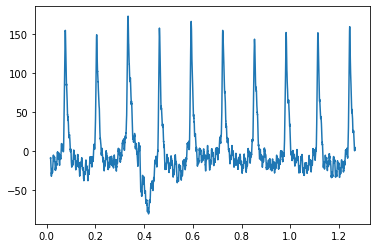

In [147]:
phys = pd.read_csv('C:/Users/schafferlab/Downloads/200_burst2_3mins_2021-05-30-18-01-10.csv')
print(phys.keys())
plt.plot(phys["Time (ms)"][0:10000]/1000,phys["ECG (mV)"][0:10000])

In [602]:
def process_fiji(file,metadata_path):
    """ process fiji output for echo pipeline. Creates dataframe used to estimate phase
    inputs: 
        file: path to file containing bmode intensity from fiji. 
        fs: sample rate of image data
        pulse_off_idx: frame number from image data indicating time 0 following ultrasound pulse off. 
    output: 
        df: dataframe containing generated timestamps (time), mouse id (mouse), 
        burst id (burst), mean bmode intensity (Mean_bmode), and timestamps relative 
        to pulse (or burst) event (time_from_burst). 
    
    """    
    # read data
    temp = pd.read_csv(file)
    metadata = pd.read_csv(metadata_path)
    basename = os.path.basename(file).split('_')
    video_name = temp.Label[0].split(':')[0]
    meta_idx = metadata["video_file"] == video_name

    # pull metadata fs,pulse_off_idx,
    fs = int(metadata["frame_rate"][meta_idx])
    pulse_off_idx = int(metadata["frame_after_burst"].loc[metadata["video_file"] == video_name])
    pulse_on_idx = int(metadata["frame_before_burst"].loc[metadata["video_file"] == video_name])

    diet = [metadata["diet"][meta_idx].values[0]]*len(temp)
    sex = [metadata["sex"][meta_idx].values[0]]*len(temp)
    

    # compute parameters
    dt = 1/fs
    n_frames = len(temp)


    # create vars 
    name = [temp["Label"][0].split("_")[2]]*len(temp) #subject id
    burst = [temp["Label"][0].split("_")[3]]*len(temp)  # burst id
    time = np.arange(dt,dt*n_frames+dt,dt) # generated timestamps
    pulse_binary = np.linspace(0,n_frames,n_frames) 
    pulse_binary = (pulse_binary <= pulse_on_idx) | (pulse_binary >= pulse_off_idx) # binary indicating frames not contaminated by pulse

    # find burst end (intensity drastically falls beyond 3 SD) 
    # ~~~~~~ NEEDS OPTIMIZATION ACRROSS BACKGROUND NOISE LEVELS ~~~~~~~ LB 01/16
    # smooth_bmode = gaussian_filter(temp.Mean,3)
    # z_diff = stats.zscore(np.diff(temp.Mean))
    # zero_point = np.where(z_diff < -3)[0]+1
    
    # create "time_after_burst" relative to time zero 
    time_from_burst = time - time[pulse_off_idx]

    # create normalize intensity relative to time before pulse
    norm_sig = norm_to_baseline(temp["Mean"],pulse_binary,time_from_burst)

    # estimate cardiac phase from bmode (filters for heart rate frequencys default 5-13Hz)
    # hr, peak_locs, filt_sig = cardiac_cylce_index(time,temp["Mean"])
    
    # build df 
    df = pd.DataFrame()
    df["mouse"] = name
    df['diet'] = diet
    df['sex'] = sex
    df["video_name"] = [temp.Label[0].split(':')[0]]*len(temp)
    df["time"] = time
    df["burst"] = burst
    df["signal"] = temp["Mean"]
    df["time after burst"] = time_from_burst
    df["pulse_binary"] = pulse_binary
    df["norm_signal"] = norm_sig
    # df["phase"] = np.round(np.angle(signal.hilbert(filt_sig)))
    # df["filt_sig"] = filt_sig

    return df 

def norm_to_baseline(sig,pulse_binary,time_after_burst):
    baseline_idx = (pulse_binary == True) & (time_after_burst < 0)
    baseline_mean = np.mean(sig[baseline_idx])
    baseline_sd = np.std(sig[baseline_idx])
    return (sig - baseline_mean) / baseline_sd

def main(data_path,metadata_path,video_path):
    """ process fiji output for echo pipeline
    input: 
        data_path: path to fiji output for bmode intensity of echo image data
        metadata_path: path to metadata csv containing, video frame rate (fs), index 
        of frame after burst(frame_after_burst), and video name (video_file) 

    output:
        
    
    """

    # file_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/bmode_mean_intensity/"
    files = glob.glob(data_path+"*.csv")

    # loop through files
    for file in files: 

        #create subfolder for file
        basename = os.path.basename(file)
        basepath = os.path.join(os.path.dirname(file),basename.split('.')[0])
        # if not os.path.exists(basepath):
        #     os.mkdir(basepath)
        # create dataframe
        df = process_fiji(file,metadata_path)
        # plot phase relative to intensity
        # plot_signal(df,basepath)
        # save images by phase into subfolders 
        # extract_image_by_phase(df,basepath,video_path)
        df.to_csv(os.path.join(basepath,'processed_'+basename))

# video_path = r'\\10.253.5.16\sn data server 3\laura_berkowitz\cardiac_grant\video_data'
# data_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/bmode_mean_intensity/"
# # files = glob.glob(file_path+"*.csv")
# # file = files[0]

# main(data_path,metadata_path,video_path)

# basename = os.path.basename(file)
# basepath = os.path.join(os.path.dirname(file),basename.split('.')[0])
# if not os.path.exists(basepath):
#     os.mkdir(basepath)

# df = process_fiji(file,metadata_path)
# plot_signal(df,basepath)
# data_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/old_data/fiji/"
# files = glob.glob(data_path+"*.csv")

# # loop through files
# for file in files: 
#     basename = os.path.basename(file)
#     df = process_fiji(file,metadata_path)

#     df.to_csv(os.path.join(os.path.dirname(file),'processed_'+basename))

### Examine 2s average of raw intensity signal

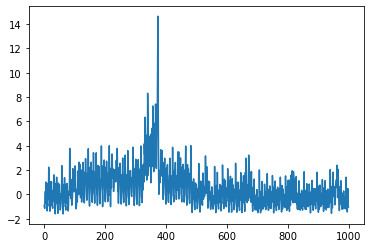

In [603]:
data_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/old_data/fiji/"
files = glob.glob(data_path+"*.csv")

df = pd.DataFrame()
# process fiji data
for file in files: 
    basename = os.path.basename(file)
    temp = process_fiji(file,metadata_path)
    temp.to_csv(os.path.join(os.path.dirname(file),'processed_'+basename))
    df = df.append(temp,ignore_index=True)

In [672]:
df


,mouse,diet,sex,video_name,time,burst,signal,time after burst,pulse_binary,norm_signal
0,711,chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,0.013889,b4,8.587,-6.750000,True,-0.905056
1,711,chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,0.027778,b4,7.963,-6.736111,True,-1.094200
2,711,chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,0.041667,b4,7.776,-6.722222,True,-1.150882
3,711,chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,0.055556,b4,10.773,-6.708333,True,-0.242446
4,711,chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,0.069444,b4,12.385,-6.694444,True,0.246175
...,...,...,...,...,...,...,...,...,...,...
2121,734,HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,12.040000,50fps-2021-11-09-17-46-55,3.651,5.700000,True,-0.689691
2122,734,HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,12.060000,50fps-2021-11-09-17-46-55,5.921,5.720000,True,1.038012
2123,734,HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,12.080000,50fps-2021-11-09-17-46-55,5.997,5.740000,True,1.095856
2124,734,HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,12.100000,50fps-2021-11-09-17-46-55,3.431,5.760000,True,-0.857133


<Figure size 720x360 with 0 Axes>

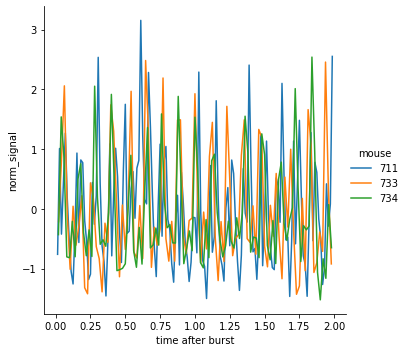

In [682]:
# fig = plt.figure(figsize=set_size('thesis', fraction=.1, subplots=(1, 1)))
fig = plt.figure(figsize=(10,5))
sns.relplot(data = df[(df["time after burst"] > 0) & (df["time after burst"] < 2)], 
            x = "time after burst",
            y = "norm_signal",
            hue = "mouse",
            palette = "tab10",
            kind = "line")



# sns.boxplot(data = df[(df["time after burst"] > 0) & (df["time after burst"] < 2)],
#             x = "diet",
#             y = "norm_signal",
#             hue = "mouse",
#             palette = "tab10",
#             )
# sns.pointplot(x="time after burst", y="norm_signal", hue = "mouse",data= df[(df["time after burst"] > 0) & (df["time after burst"] < 2)])
# color = 
# for mouse in np.unique(df["mouse"]):
    
#     temp = df[(df["mouse"] == mouse) & (df["time after burst"] > 0)]
#     signal = gaussian_filter(temp["norm_signal"],5)
#     plt.plot(temp["time after burst"],signal,linewidth=5)
#     plt.plot(temp["time after burst"],temp["norm_signal"])

#     # bins = np.arange(0, np.max(temp["time after burst"]),2)
    # binned_signal
    # sns.pointplot(data = temp, np.histogram(temp["norm_signal"],bins)[0])


# sns.boxplot(data = df[(df["time after burst"] > 0)],
#             x = "time after burst",
#             y = "norm_signal",
#             hue = "mouse")

# sns.replot()

In [542]:
df_proc = pd.read_csv("C:/Users/schafferlab/Desktop/711_b4_sanitycheck.csv")
df_proc.columns = df_proc.columns.str.replace(' ','')
df_proc

,Slice,time,ROI1,ROI2,ROI3,avg
0,491,6.819444,10.82927,7.41858,13.46331,10.570387
1,500,6.944444,11.81559,7.99938,14.89536,11.570110
2,517,7.180556,11.91353,7.27905,13.44412,10.878900
3,552,7.666667,13.53326,7.91899,15.60108,12.351110
4,561,7.791667,17.65041,9.51770,21.04505,16.071053
5,587,8.152778,19.79934,11.67555,23.17694,18.217277
6,630,8.750000,19.87491,11.67534,23.16873,18.239660
7,656,9.111111,19.03049,10.31674,20.41749,16.588240
8,734,10.194444,19.76922,12.48167,21.13885,17.796580
9,760,10.555556,17.50314,11.33694,18.18762,15.675900


[ 1.31630636e+00  1.91389256e+01 -7.16630589e+04]


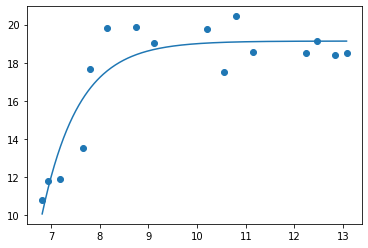

In [534]:
from scipy.optimize import curve_fit 
from scipy.stats import expon

def func(x,a,b,c):
    return (b-c) * (1 - np.exp(-a*x)) + c

x = np.linspace(np.min(df_proc["time"]),np.max(df_proc["time"]),300)

popt,pcov = curve_fit(func,df_proc["time"],df_proc["ROI1"])
y_pred = func(x,*popt)
print(popt)

plt.scatter(df_proc["time"],df_proc["ROI1"])
plt.plot(x,y_pred)


### Plot all available data of posterior wall intensity following pulse

<Figure size 106.299x65.6965 with 0 Axes>

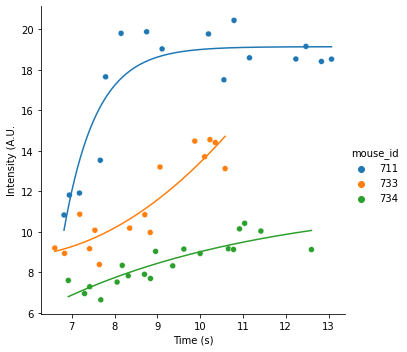

In [541]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

data_path = '//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/contrast_image_intensity/'
files = glob.glob(data_path+'*.csv')

# def func(x,a,b,c):
#     return (b-c) * (1 - np.exp(-a*x)) + c
    

polyreg=make_pipeline(PolynomialFeatures(2),LinearRegression())

df = pd.DataFrame()
for file in files:
    temp_df = pd.read_csv(file)
    df = df.append(temp_df,ignore_index=True)

fig = plt.figure(figsize=set_size('thesis', fraction=.25, subplots=(1, 1)))
sns.relplot(data = df, 
            x = "time",
            y = "roi_1",
            hue = "mouse_id",
            palette = "tab10")

plt.xlabel('Time (s)')
plt.ylabel('Intensity (A.U.')

# plot fit
for mouse in np.unique(df["mouse_id"]):
    # X = df[df.mouse_id == mouse].time.values.reshape(-1, 1)
    # y = df[df.mouse_id == mouse].roi_1.values
    # X_seq = np.linspace(X.min(),X.max(),16).reshape(-1,1)

    # polyreg.fit(X,y)
    # plt.plot(X_seq,polyreg.predict(X_seq))
    def func(x,a,b,c):
        return (b-c) * (1 - np.exp(-a*x)) + c
        
    try: 
        x = np.linspace(np.min(df["time"][df.mouse_id == mouse]),np.max(df["time"][df.mouse_id == mouse]),300)
        popt,pcov = curve_fit(func,df["time"][df.mouse_id == mouse],df["roi_1"][df.mouse_id == mouse])
        y_pred = func(x,*popt)
        plt.plot(x,y_pred)
    except: 
        x = np.linspace(np.min(df["time"][df.mouse_id == mouse]),np.max(df["time"][df.mouse_id == mouse]),300).reshape(-1,1)
        X = df[df.mouse_id == mouse].time.values.reshape(-1, 1)
        y = df[df.mouse_id == mouse].roi_1.values
        polyreg.fit(X,y)
        plt.plot(x,polyreg.predict(x))

    plt.savefig(save_path+"PW_intensity_across_mice.svg",dpi = 300, bbox_inches = "tight")



In [555]:
# convert time to time after burst 
metadata = pd.read_csv("//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/meta_data.csv")
metadata[(metadata.mouse_id == 711) | (metadata.mouse_id == 734) | (metadata.mouse_id == 733)]



TypeError: _linspace_dispatcher() missing 1 required positional argument: 'stop'

In [683]:
(77.5*2) + (104*2) + (13*4)

415.0